# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [1]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 3.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [209]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [210]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [211]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


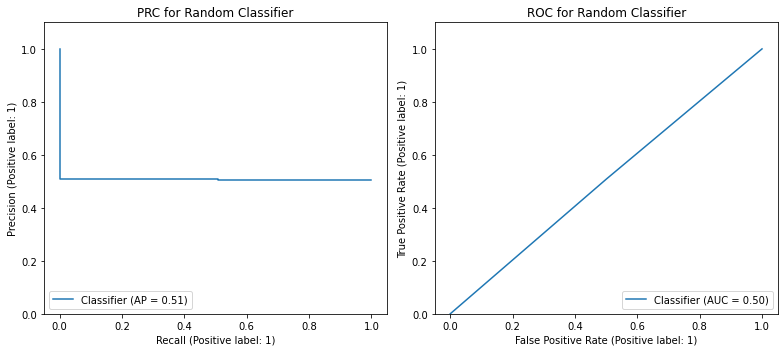

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [213]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__ 



Комментарий от меня: я погуглила, как подбирать гиперпараметр через GridSearchCV с точки зрения AUC-PR и нашла [это](https://stackoverflow.com/questions/68567722/how-to-use-precision-recall-curve-in-gridsearchcv), поэтому в качестве scoring добавим <code>average_precision</code>

Best C = 0.0728


Text(0, 0.5, 'CV score')

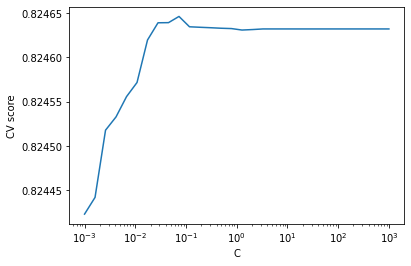

In [215]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

cs = np.logspace(-3, 3, 30)
searcher = GridSearchCV(LinearSVC(dual=False), [{"C": cs}], scoring="average_precision", cv=10)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best C = %.4f" % best_C)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.82969
AUC-ROC: 0.84765


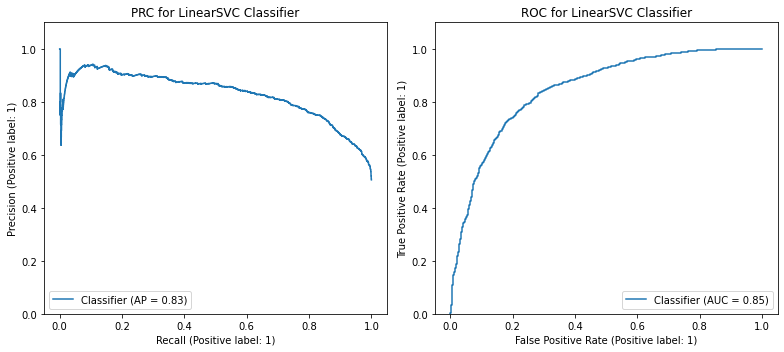

In [218]:
model = LinearSVC(C=best_C, dual=False)
model.fit(X_train, y_train)
pred = model.decision_function(X_test)
pred = (pred - pred.min()) / (pred.max() - pred.min())

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [219]:
df_metrics.loc['LinearSVC Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, pred),
    best_C
]

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

Best C = 0.0005


Text(0, 0.5, 'CV score')

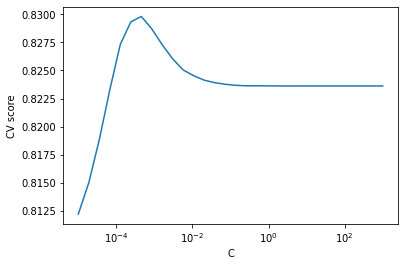

In [220]:
from sklearn.linear_model import LogisticRegression

cs = np.logspace(-5, 3, 30)
searcher = GridSearchCV(LogisticRegression(dual=False, penalty='l2'), [{"C": cs}], scoring="average_precision", cv=10)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best C = %.4f" % best_C)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

AUC-PR: 0.83465
AUC-ROC: 0.84298


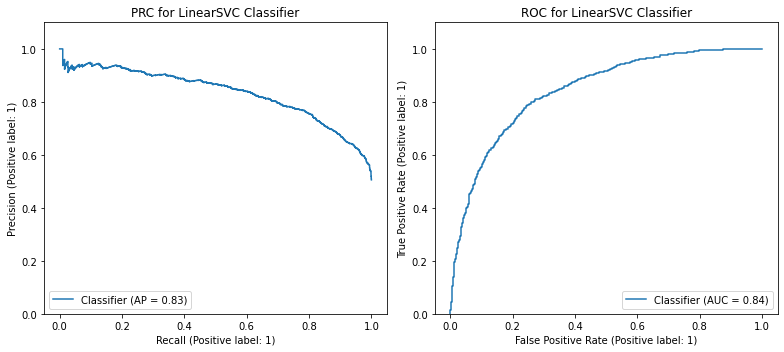

In [222]:
model = LogisticRegression(C=best_C, dual=False, penalty='l2')
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [223]:
df_metrics.loc['Logistic Regression'] = [
    auc(recall, precision),
    roc_auc_score(y_test, pred),
    best_C
]

In [224]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
LinearSVC Classifier,0.829686,0.847651,0.072790
Logistic Regression,0.834652,0.842982,0.000452


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: SVM чуть лучше чем LR по AUC_ROC, LR чуть лучше SVC по AUC_PR, SVM намного слабее наказывает модель за большие веса (C – это inverse  of regularization strength, для LR значение намного меньше, чем для SVC)
 

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [225]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Best C = 0.0009


Text(0, 0.5, 'CV score')

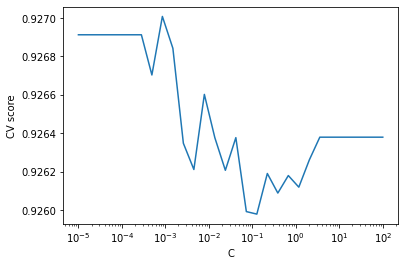

In [226]:
from sklearn.svm import SVC

cs = np.logspace(-5, 2, 30)
searcher = GridSearchCV(SVC(kernel='linear', max_iter=-1), [{"C": cs}], scoring="average_precision", cv=10)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best C = %.4f" % best_C)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

Number of support vectors: 642


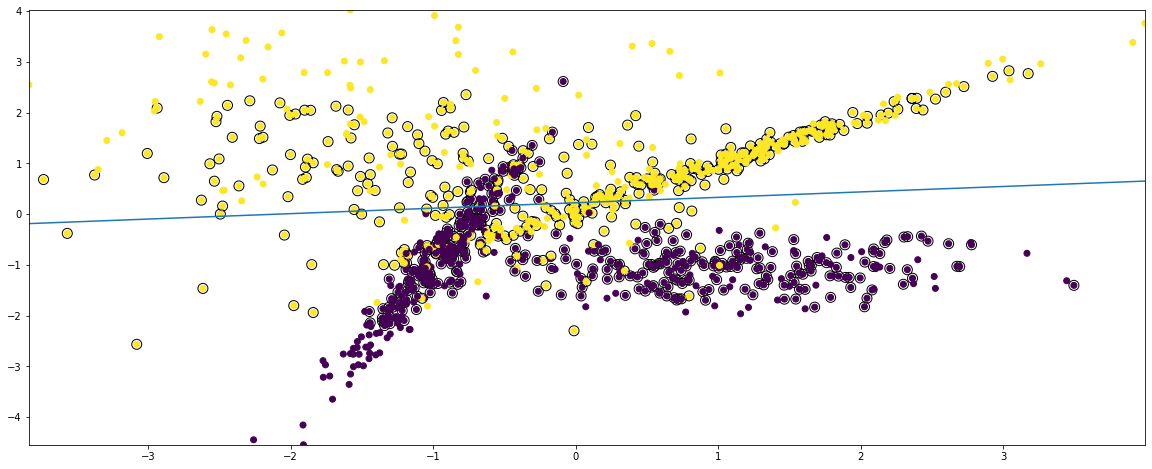

In [227]:
model = SVC(C=best_C, kernel='linear', max_iter=-1)
model.fit(X_train, y_train)

support_vectors = model.support_vectors_

# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
fig = plt.figure(figsize=(20, 8))
fig = plt.scatter(
    support_vectors[:, 0],
    support_vectors[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

print('Number of support vectors:', support_vectors.shape[0])


X1min, X2min = X.min(axis=0)
X1max, X2max = X.max(axis=0)
x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                     np.linspace(X2min, X2max, 200))
ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
ypred = ypred.reshape(x1.shape)

# ax1 = plt.contourf(x1, x2, ypred, alpha=.4) # а было красиво
x_to_plot = np.linspace(X1min, X1max, 200)
ax1 = plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim(X1min, X1max)
plt.ylim(X2min, X2max)
ax1 = plt.plot(x_to_plot, -model.coef_[0][0] * x_to_plot / model.coef_[0][1] - model.intercept_ / model.coef_[0][1]) 

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [228]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # середина отрезка это сумма границ пополам
#         print(y_test[(preds >= l) & (preds < r)] == 1)
#         print(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))  # тут не np.min, а np.mean, как раз будет доля единиц
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [297]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Best C = 35.6225


Text(0, 0.5, 'CV score')

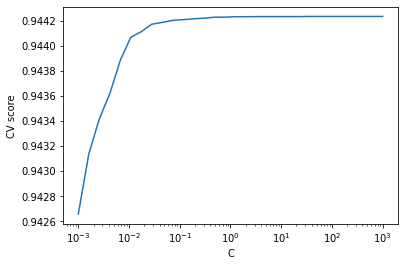

In [230]:
cs = np.logspace(-3, 3, 30)
searcher = GridSearchCV(LinearSVC(dual=False), [{"C": cs}], scoring="average_precision", cv=10)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best C = %.4f" % best_C)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

AUC-PR: 0.93822
AUC-ROC: 0.94611


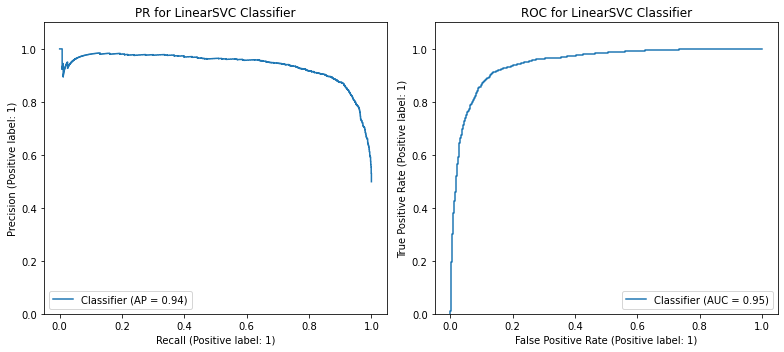

In [239]:
model = LinearSVC(C=best_C, dual=False)
model.fit(X_train, y_train)
pred = model.decision_function(X_test)
pred = (pred - pred.min()) / (pred.max() - pred.min())

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

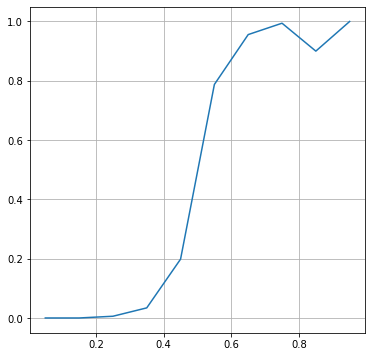

In [240]:
svc_pred = model.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, pred)

Best C = 0.4894


Text(0, 0.5, 'CV score')

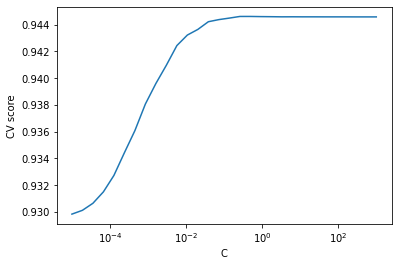

In [241]:
cs = np.logspace(-5, 3, 30)
searcher = GridSearchCV(LogisticRegression(dual=False, penalty='l2'), [{"C": cs}], scoring="average_precision", cv=10)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best C = %.4f" % best_C)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

AUC-PR: 0.93881
AUC-ROC: 0.94627


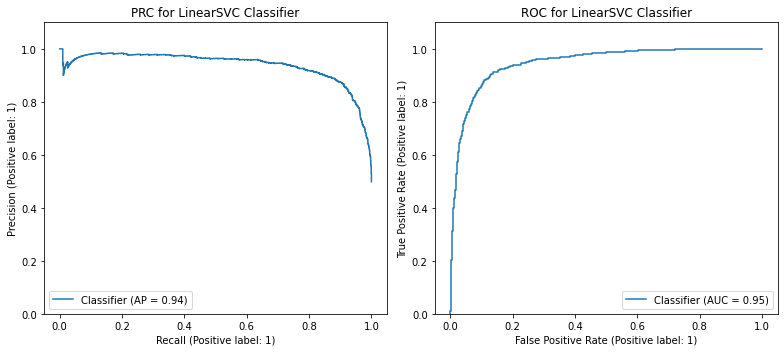

In [247]:
model = LogisticRegression(C=best_C, dual=False, penalty='l2')
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

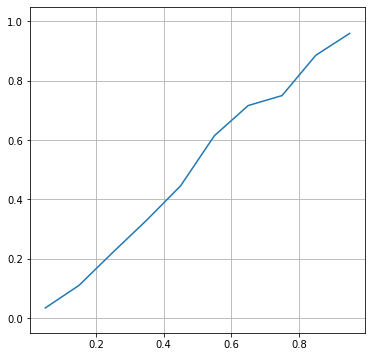

In [248]:
lr_pred = model.predict_proba(X_test)
plot_calibration_curve(y_test, lr_pred[:, 1])

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

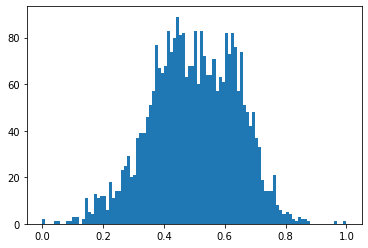

In [249]:
plt.hist(svc_pred, bins=100)
plt.show()

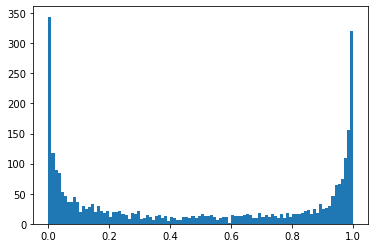

In [250]:
plt.hist(lr_pred[:, 1], bins=100)
plt.show()

Чем они различаются? Чем вы можете объяснить это?

Ответ: Кривая для логистической регрессии хорошо приближает диагональ, для SVC – нет, у логистической регрессии бОльшая часть предсказаний имеют большУю уверенность (находятся в левом или правом краях гистограммы), а у SVC вероятности сосредоточены в центре гистограммы – модель не уверена, принадлежит объект к отрицательному или положительному классу

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

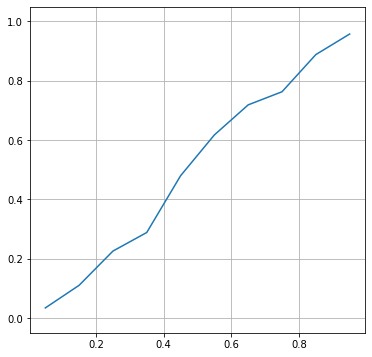

In [251]:
from sklearn.calibration import CalibratedClassifierCV

base_clf = LinearSVC(C=35.6225, dual=False)
calibrated_clf = CalibratedClassifierCV(base_estimator=base_clf, cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_pred = calibrated_clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, calibrated_pred)

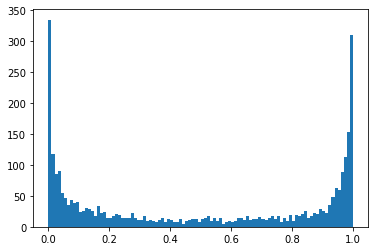

In [254]:
plt.hist(calibrated_pred, bins=100)
plt.show()

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

На семинаре модели, откалиброванные при помощи изотонической калибровки, переобучились (см. картинку), поэтому попробуем калибровку Платта
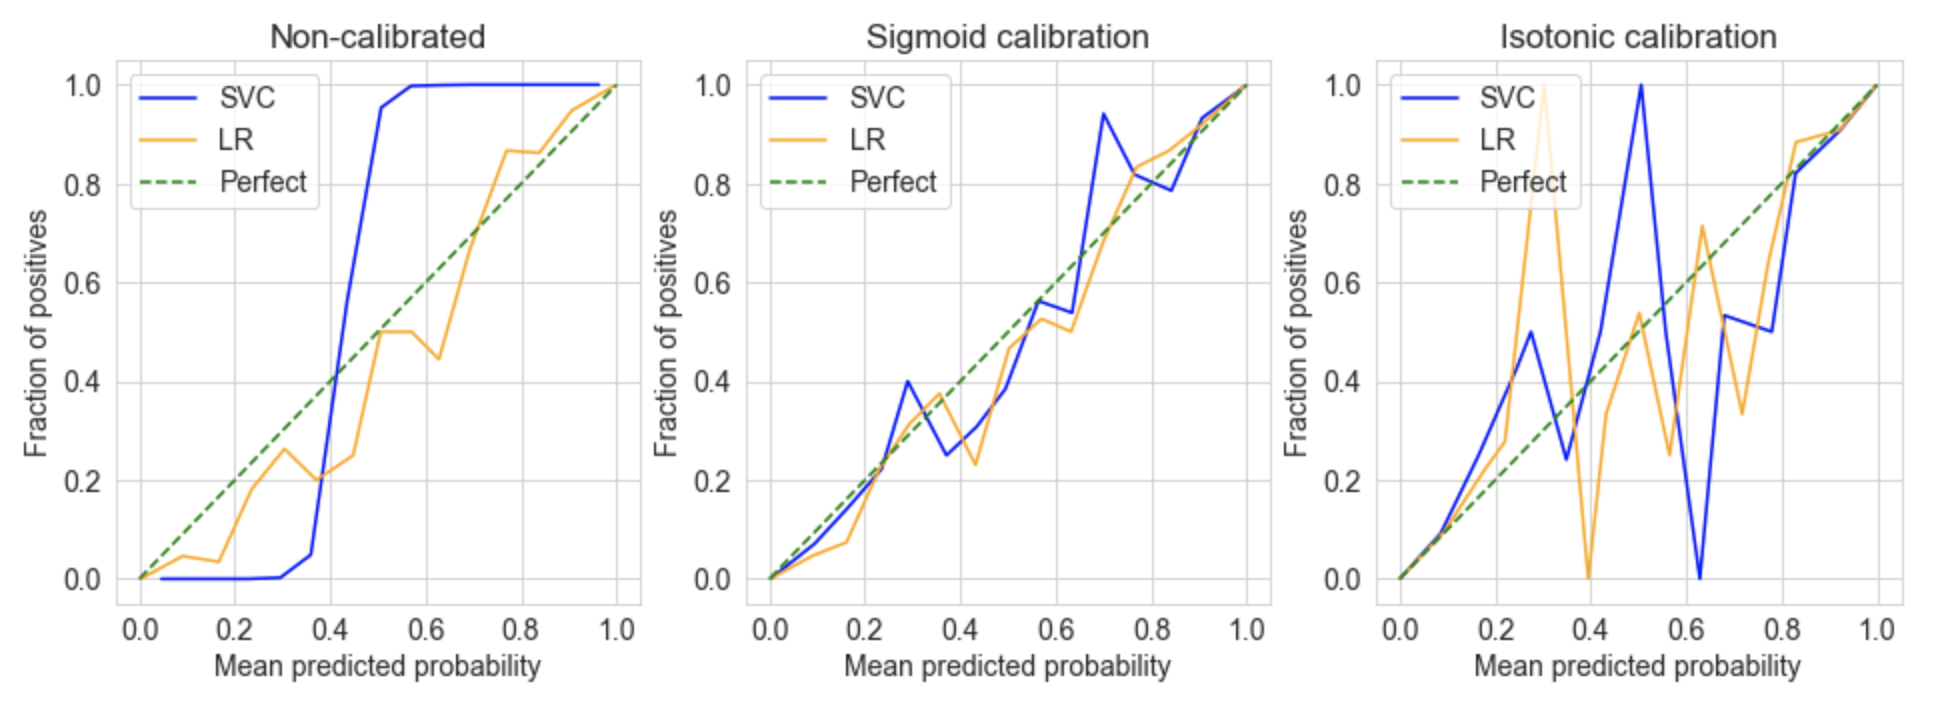

Калибровка Платта via [6 семинар](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem06-calibration.ipynb) 

Допустим, у нас есть обученный класификатор $b(x)$, который выдает уверенность (скор) в том, что $x$ относится к положительному классу. Метод приближает вероятность положительного класса с помощью сигмоидной функции:
$$
p(y=+1 \mid b(x))=\frac{1}{1+\exp (A \cdot b(x)+C)}
$$

Качество будем измерять по логлоссу, параметры будем подбирать по отложенной выборке

In [313]:
# сделаем тРанСфОрмЕр, а не просто функцию: для этого будем наследоваться от BaseEstimator и TransformerMixin
# надо реализовать __init__, fit и transform

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import log_loss

class PlattCalibrationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, predictions):
        self.A = None
        self.B = None
        self.as_ = np.logspace(-3, 2, 10) # я тут поперебирала и вроде такое даёт норм результат
        self.bs_ = np.logspace(-3, 2, 10)
        self.predictions = predictions # приходят нам из неоткалиброванного классификатора
        self.calibrated_preds = None
        
    def get_predictions(self, a=0, b=0, predictions=None):
        if a == b == 0: # если не проинциализированные, я не поняла, как передать self.A и self.B как дефолтные
            a, b = self.A, self.B
        if predictions is None:
            predictions = self.predictions
        return 1 / (1 + np.exp(-a * predictions - b))
    
    def fit(self, X, y):
        best_loss = 10 ** 5
        for a in self.as_:
            for b in self.bs_:
#                 print(a, b)
                cur_preds = self.get_predictions(a=a, b=b, predictions=self.predictions)  
                loss = log_loss(y, cur_preds)
                if loss < best_loss:
                    best_loss = loss
                    self.A, self.B = a, b
                    self.calibrated_preds = cur_preds
        return self
    
    def transform(self, X):
        return X

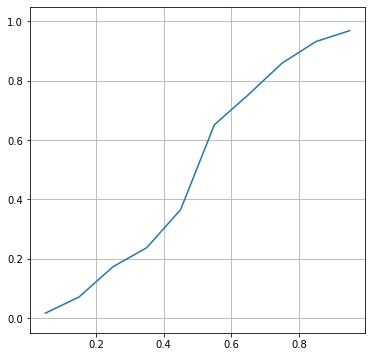

In [314]:
model = LinearSVC(C=best_C, dual=False)
model.fit(X_train, y_train)

X_val_, X_test_, y_val_, y_test_ = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

val_predictions = model.decision_function(X_val_)
test_predictions = model.decision_function(X_test_)
platt = PlattCalibrationTransformer(val_predictions)
platt.fit(X_val_, y_val_)
plot_calibration_curve(y_test_, platt.get_predictions(predictions=test_predictions))

Ура! Кривая приблизилась к диагонали, посмотрим на AUC-ROC и AUC-PR

AUC-PR: 0.94256
AUC-ROC: 0.94697


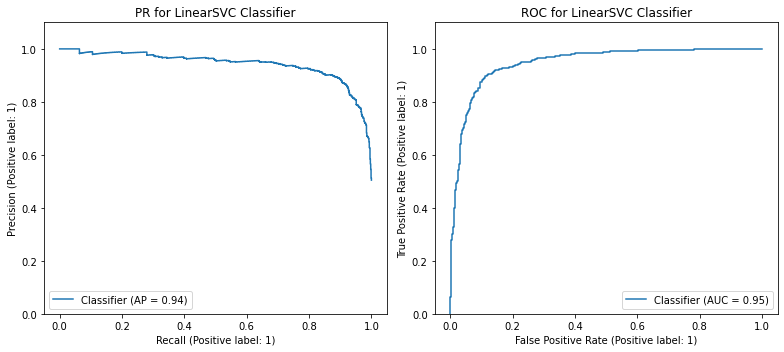

In [317]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test_, platt.get_predictions(predictions=test_preds), ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test_, platt.get_predictions(predictions=test_preds))
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test_, platt.get_predictions(predictions=test_preds), ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test_, platt.get_predictions(predictions=test_preds)))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

AUC-PR стала чуть больше по сравнению с неоткалиброванной моделью

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [255]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-16 22:10:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3,8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3,79M   545KB/s    in 7,8s    

2022-11-16 22:10:57 (497 KB/s) - ‘adult.data’ saved [3974305/3974305]



In [256]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [257]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [322]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [342]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder


categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                       'race', 'sex', 'native-country']
numeric_features = list(set(df.drop(columns=['income']).columns) - set(categorical_features))

ordinal_column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])


pipeline = Pipeline([
    ('ohe_and_scaling', ordinal_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

CPU times: user 1.33 s, sys: 169 ms, total: 1.5 s
Wall time: 297 ms


Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe', OrdinalEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('scaling', StandardScaler(),
                                                  ['capital-loss', 'age',
                                                   'education-num', 'fnlwgt',
                                                   'capital-gain',
                                                   'hours-per-week'])])),
                ('regression', LogisticRegression(max_iter=2147483647))])

AUC-PR: 0.68224
AUC-ROC: 0.85228


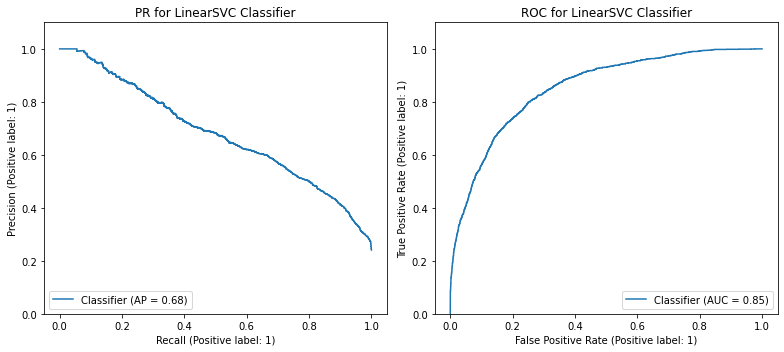

In [279]:
pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [280]:
y.value_counts()

0    24720
1     7841
Name: income, dtype: int64

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: у нас несбалансированные классы, положительный сильно меньше отрицательного по размеру, а `AUC-ROC` измеряет долю неверно принятых объектов относительно общего числа отрицательных, то есть у не самого лучшего алгоритма показатели могут быть близки к показателям оптимального алгоритма. `AUC-PR` решает эту проблему тем, что измеряет не TPR и FPR, а полноту и точность

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [281]:
onehot_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])


pipeline = Pipeline([
    ('ohe_and_scaling', onehot_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

CPU times: user 495 ms, sys: 7.85 ms, total: 503 ms
Wall time: 502 ms


Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('scaling', StandardScaler(),
                                                  ['capital-loss', 'age',
                                                   'education-num', 'fnlwgt',
                                                   'capital-gain',
                                                   'hours-per-week'])])),
                ('regression', LogisticRegression(max_iter=2147483647))])

AUC-PR: 0.76714
AUC-ROC: 0.90699


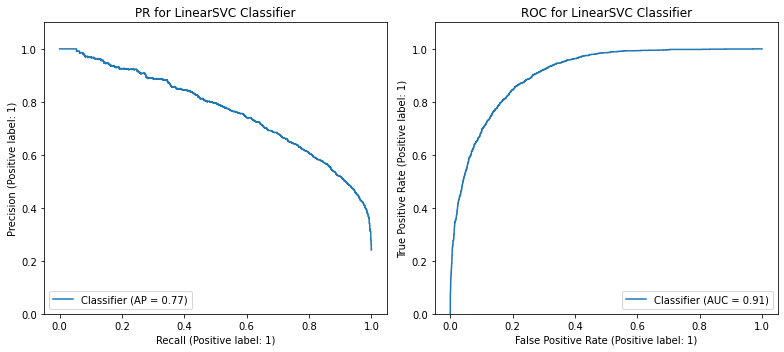

In [282]:
pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

Примечание: дальше я напишу трансформер и буду использовать его, но сначала посмотрю, как работает encoder из модуля category_encoders

In [283]:
# ! pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 697.8 kB/s eta 0:00:000:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [287]:
# Посмотрим, как должно работать 
from category_encoders.target_encoder import TargetEncoder

target_column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=1.0), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe_and_scaling', target_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


CPU times: user 748 ms, sys: 77.9 ms, total: 826 ms
Wall time: 399 ms


Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te', TargetEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('scaling', StandardScaler(),
                                                  ['capital-loss', 'age',
                                                   'education-num', 'fnlwgt',
                                                   'capital-gain',
                                                   'hours-per-week'])])),
                ('regression', LogisticRegression(max_iter=2147483647))])

AUC-PR: 0.75578
AUC-ROC: 0.90198


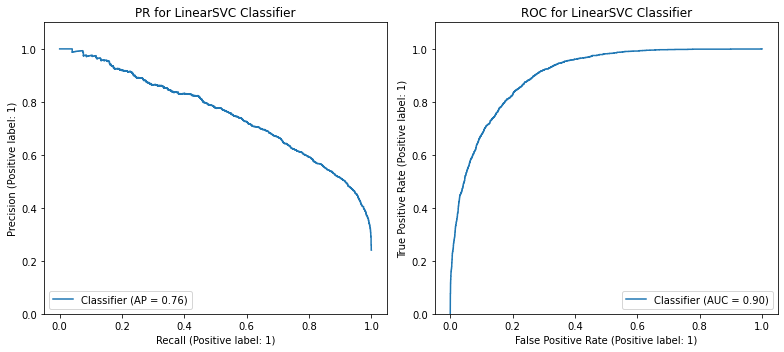

In [288]:
pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

Скопирую условие ещё раз просто для удобства: 
> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

In [324]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.means = {}
        self.categories = categories
        
    
    def fit(self, data, target):
        for c in self.categories:
            means = {}
            for value in np.unique(data[c]):
                means[value] = np.mean(target[data[c] == value])
            self.means[c] = means
        return self
            
    
    def transform(self, data):
        data_ = data.copy()
        for c in self.categories:
            for value in np.unique(data[c]):
                if value not in self.means[c].keys():
                    data_.loc[data[c] == value, c + '_encoded'] = 0
                else:
                    data_.loc[data[c] == value, c + '_encoded'] = self.means[c][value]
        data_ = data_.drop(columns=self.categories)
        return data_
    
target_column_transformer = ColumnTransformer([
    ('te', MeanTargetEncoder(categories=categorical_features), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe_and_scaling', target_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

CPU times: user 981 ms, sys: 70 ms, total: 1.05 s
Wall time: 597 ms


Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te',
                                                  MeanTargetEncoder(categories=['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country']),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('scaling', StandardScaler(),
                                                  ['capital-loss', 'age',
                                                   'education-num', 'fnlwgt',
                                                   'capital-gain',
                                                   'hours-per-week'])])),
                ('regression', LogisticRegression(max_iter=2147483647))])

AUC-PR: 0.75579
AUC-ROC: 0.90198


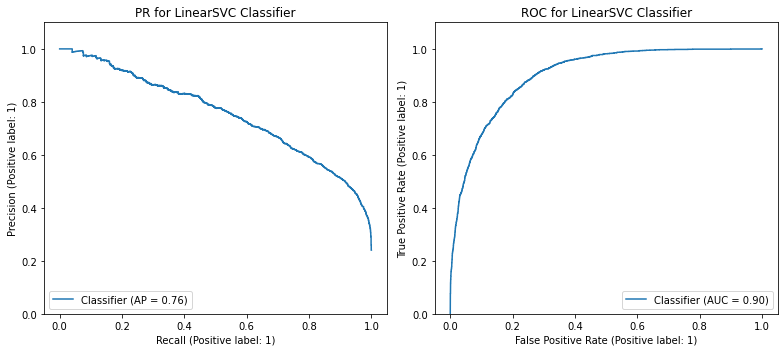

In [326]:
pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Работает точно так же, как и TargetEncoder из category_encoders, значения AUC-PR совпадают в четырёх цифрах после запятой, AUC-ROC – как минимум в пяти (ура)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [331]:
class NoisedMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories, noise=0.5):
        self.means = {}
        self.categories = categories
        self.noise = noise
        
    
    def fit(self, data, target):
        for c in self.categories:
            means = {}
            for value in np.unique(data[c]):
                means[value] = np.mean(target[data[c] == value]) + np.random.normal(scale=self.noise)
            self.means[c] = means
        return self
            
    
    def transform(self, data):
        data_ = data.copy()
        for c in self.categories:
            for value in np.unique(data[c]):
                if value in self.means[c].keys():
                    data_.loc[data[c] == value, c + '_encoded'] = self.means[c][value]
                else:
                    data_.loc[data[c] == value, c + '_encoded'] = np.random.normal(scale=self.noise)
        data_ = data_.drop(columns=self.categories)
        return data_

    
best_AUC_PR = None
best_AUC_ROC = None
best_noise = None
for noise in np.logspace(-3, 2, 10):
    target_column_transformer = ColumnTransformer([
        ('te', NoisedMeanTargetEncoder(categories=categorical_features, noise=noise), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ], remainder='passthrough')

    pipeline = Pipeline([
        ('ohe_and_scaling', target_column_transformer),
        ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
    ])

    %time pipeline.fit(X_train, y_train)

    pred = pipeline.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, pred)
    AUC_PR = auc(recall, precision)
    AUC_ROC = roc_auc_score(y_test, pred)
    if best_AUC_PR is None or best_AUC_PR < AUC_PR:
        best_AUC_PR = AUC_PR
        best_AUC_ROC = AUC_ROC
        best_noise = noise

print(f'best AUC-PR: {best_AUC_PR}, best AUC_ROC: {best_AUC_ROC}, best noise: {best_noise}')

CPU times: user 1.01 s, sys: 63.9 ms, total: 1.07 s
Wall time: 597 ms
CPU times: user 1.43 s, sys: 139 ms, total: 1.57 s
Wall time: 560 ms
CPU times: user 1.38 s, sys: 140 ms, total: 1.52 s
Wall time: 554 ms
CPU times: user 1.45 s, sys: 143 ms, total: 1.59 s
Wall time: 566 ms
CPU times: user 1.65 s, sys: 157 ms, total: 1.81 s
Wall time: 597 ms
CPU times: user 1.06 s, sys: 89.7 ms, total: 1.15 s
Wall time: 479 ms
CPU times: user 1.08 s, sys: 92.4 ms, total: 1.17 s
Wall time: 483 ms
CPU times: user 1.59 s, sys: 147 ms, total: 1.74 s
Wall time: 579 ms
CPU times: user 2.05 s, sys: 198 ms, total: 2.25 s
Wall time: 666 ms
CPU times: user 2.25 s, sys: 232 ms, total: 2.48 s
Wall time: 705 ms
best AUC-PR: 0.755963171590998, best AUC_ROC: 0.9020526201096843, best noise: 0.01291549665014884


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [332]:
class SmoothingMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories, C=10):
        self.means = {}
        self.categories = categories
        self.C = C
        
    
    def fit(self, data, target):
        for c in self.categories:
            means = {}
            for value in np.unique(data[c]):
                means[value] = (np.sum(target[data[c] == value]) + self.C * np.mean(target)) / (len((data[c] == value)) + self.C)
            self.means[c] = means
        return self
            
    
    def transform(self, data):
        data_ = data.copy()
        for c in self.categories:
            for value in np.unique(data[c]):
                if value in self.means[c].keys():
                    # будем создавать новые колонки, а старые дропнем
                    data_.loc[data[c] == value, c + '_encoded'] = self.means[c][value]
                else:
                    data_.loc[data[c] == value, c + '_encoded'] = 0
        data_ = data_.drop(columns=self.categories)
        return data_
    
best_AUC_PR = None
best_AUC_ROC = None
best_C_for_smoothing = None
for C in np.logspace(-3, 3, 10):
    target_column_transformer = ColumnTransformer([
        ('te', SmoothingMeanTargetEncoder(categories=categorical_features, C=C), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ], remainder='passthrough')

    pipeline = Pipeline([
        ('ohe_and_scaling', target_column_transformer),
        ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
    ])

    %time pipeline.fit(X_train, y_train)

    pred = pipeline.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, pred)
    AUC_PR = auc(recall, precision)
    AUC_ROC = roc_auc_score(y_test, pred)
    if best_AUC_PR is None or best_AUC_PR < AUC_PR:
        best_AUC_PR = AUC_PR
        best_AUC_ROC = AUC_ROC
        best_C_for_smoothing = C

print(f'best AUC-PR: {best_AUC_PR}, best AUC_ROC: {best_AUC_ROC}, best C: {best_C_for_smoothing}')

CPU times: user 1.31 s, sys: 85.9 ms, total: 1.4 s
Wall time: 748 ms
CPU times: user 1.85 s, sys: 197 ms, total: 2.05 s
Wall time: 846 ms
CPU times: user 1.81 s, sys: 170 ms, total: 1.97 s
Wall time: 812 ms
CPU times: user 1.59 s, sys: 136 ms, total: 1.73 s
Wall time: 724 ms
CPU times: user 1.71 s, sys: 168 ms, total: 1.87 s
Wall time: 775 ms
CPU times: user 1.76 s, sys: 163 ms, total: 1.93 s
Wall time: 761 ms
CPU times: user 1.66 s, sys: 147 ms, total: 1.81 s
Wall time: 718 ms
CPU times: user 1.59 s, sys: 137 ms, total: 1.73 s
Wall time: 681 ms
CPU times: user 1.56 s, sys: 129 ms, total: 1.69 s
Wall time: 677 ms
CPU times: user 1.65 s, sys: 140 ms, total: 1.79 s
Wall time: 687 ms
best AUC-PR: 0.7477257371301284, best AUC_ROC: 0.8971170704165827, best C: 0.1


Стало только хуже

#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [335]:
len(np.unique(X['age'])) # уникальных возрастов

73

In [338]:
len(np.unique(X['hours-per-week'])) # уникальных количеств рабочих часов в неделю

94

Поскольку в предыдущих заданиях лучше всего показал себя обычный MeanTargetEncoder, будем использовать именно его

CPU times: user 981 ms, sys: 72.6 ms, total: 1.05 s
Wall time: 630 ms
AUC-PR: 0.76433
AUC-ROC: 0.90634


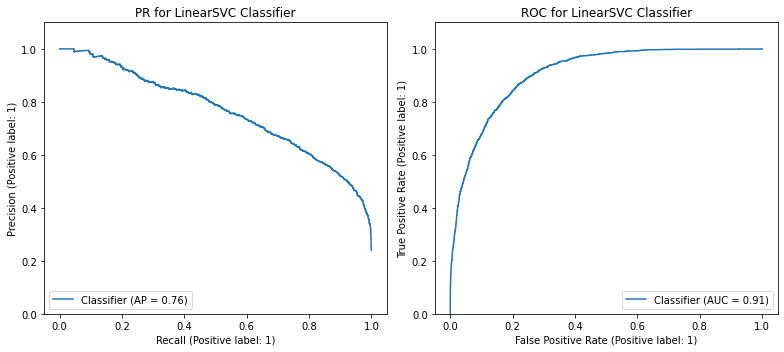

In [339]:
# только возраст

target_column_transformer = ColumnTransformer([
    ('te', MeanTargetEncoder(categories=categorical_features + ['age']), categorical_features + ['age']),
    ('scaling', StandardScaler(), numeric_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe_and_scaling', target_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

CPU times: user 1.04 s, sys: 69.1 ms, total: 1.11 s
Wall time: 654 ms
AUC-PR: 0.75521
AUC-ROC: 0.90201


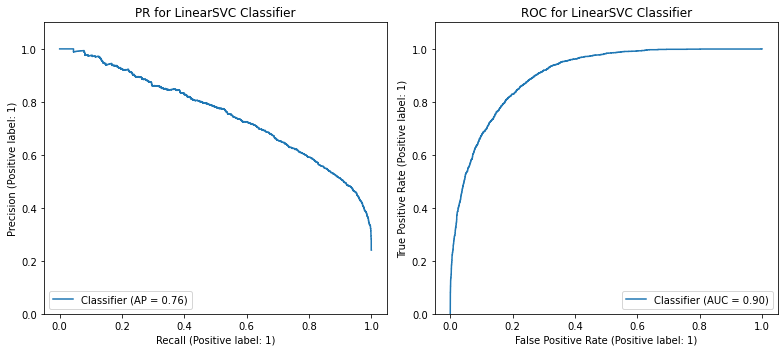

In [340]:
target_column_transformer = ColumnTransformer([
    ('te', MeanTargetEncoder(categories=categorical_features + ['hours-per-week']), categorical_features + ['hours-per-week']),
    ('scaling', StandardScaler(), numeric_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe_and_scaling', target_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

CPU times: user 1.13 s, sys: 85.6 ms, total: 1.21 s
Wall time: 721 ms
AUC-PR: 0.76355
AUC-ROC: 0.90645


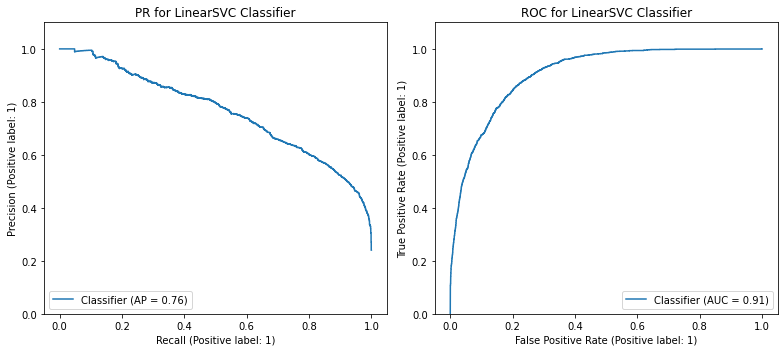

In [341]:
target_column_transformer = ColumnTransformer([
    ('te', MeanTargetEncoder(categories=categorical_features + ['age', 'hours-per-week']), categorical_features + ['age', 'hours-per-week']),
    ('scaling', StandardScaler(), numeric_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe_and_scaling', target_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Лучший результат (по AUC-PR, 0.76433) получился, когда мы начали кодировать age, но не начали кодировать hours-per-week

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ из плюсов: при использовании счётчиков будет меньше новых признаков и, следовательно, будет тратиться меньше памяти; из минусов: счётчики работают дольше, чем one hot encoder, и качество получилось хуже

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [414]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [415]:
X, y = df.drop(columns=['income']), df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [416]:
print(f'Признаков до ohe: {len(X_train.columns)}')

onehot_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

X_train_transformed = onehot_column_transformer.fit_transform(X_train)
print(f'Признаков после ohe: {X_train_transformed.shape[1]}')
print(f'Новых признаков: {X_train_transformed.shape[1] - len(X_train.columns)}')

Признаков до ohe: 14
Признаков после ohe: 108
Новых признаков: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

CPU times: user 498 ms, sys: 4.2 ms, total: 502 ms
Wall time: 501 ms
AUC-PR: 0.76714
AUC-ROC: 0.90699


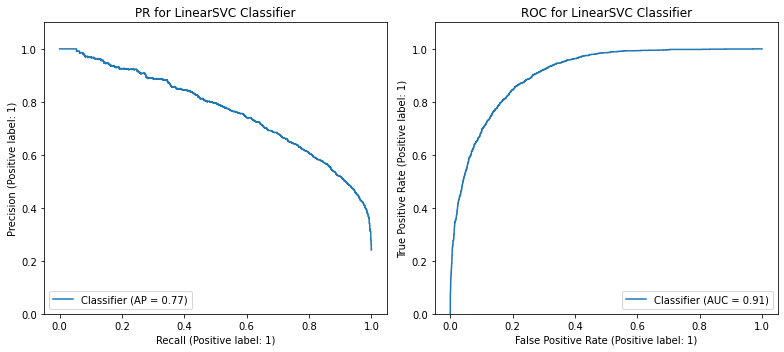

In [417]:
pipeline = Pipeline([
    ('ohe_and_scaling', onehot_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

%time pipeline.fit(X_train, y_train)

pred = pipeline.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Запоминаем! 0.76714

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [418]:
pipeline.steps[1][1].coef_[0]
# чтобы вытащить коэффициенты из пайплайна

array([-0.04456558,  0.715391  , -0.02473823, -0.1381292 ,  0.23114554,
        0.31080762, -0.24105167, -0.04999943, -0.78300621, -0.08855183,
       -0.24475361, -0.04390795,  0.64577182,  0.66277551,  0.12218906,
        0.06917303, -0.32494156, -0.08348006, -0.07182704,  0.21001752,
       -0.05801611,  0.06966335, -1.08288885,  0.2356012 , -0.04097065,
       -0.5127218 ,  1.78691158,  1.58486225, -0.71583621, -1.05052044,
       -0.79773388, -0.31910768, -0.18269478,  0.20472143, -0.20257029,
        0.24296484,  0.93974118, -0.93583302, -0.3751272 , -0.08514045,
       -0.68864378, -1.53804825,  0.64747102,  0.7661688 ,  0.42774911,
        0.71851604,  0.03657919, -0.18113006,  0.29631638, -0.5914288 ,
       -0.85096104,  0.1754465 ,  1.12761085, -0.35104215,  0.31379762,
        0.00814378, -0.18527535,  0.19022993, -0.450788  ,  0.42664182,
        0.02530723,  0.85431345,  0.88619481, -0.14935327, -1.1986715 ,
        0.47687952, -0.85110364, -0.29985623, -0.4702943 ,  0.44

In [419]:
N = 40

weights = pipeline.steps[1][1].coef_[0]
bound = sorted(np.abs(weights), reverse = True)[N]
idxs = np.where(abs(weights) >= bound)[0][:N] # вдруг одинаковые веса

# print(idxs)

onehot_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

X_train_transformed = onehot_column_transformer.fit_transform(X_train)
X_train_shrinked = X_train_transformed.toarray()[:, idxs]
X_train_shrinked.shape

(24420, 40)

AUC-PR: 0.66612
AUC-ROC: 0.87476


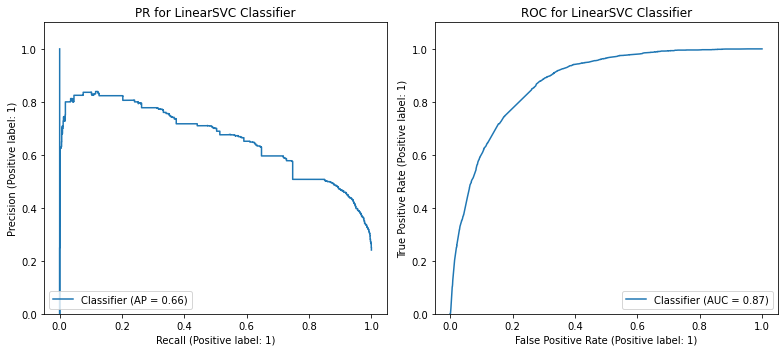

In [420]:
logreg_after_shrinkage = LogisticRegression(max_iter = 2 ** 31 - 1)
logreg_after_shrinkage.fit(X_train_shrinked, y_train)

X_test_shrinked = onehot_column_transformer.transform(X_test).toarray()[:, idxs]

pred = logreg_after_shrinkage.predict_proba(X_test_shrinked)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Изменилось ли качество? Как?

<b>Качество сильно ухудшилось</b>

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [421]:
onehot_column_transformer_wo_scaling = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features)
#     ('scaling', StandardScaler(), numeric_features)
])

pipeline_wo_scaling = Pipeline([
    ('ohe', onehot_column_transformer_wo_scaling),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

pipeline_wo_scaling.fit(X_train, y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('regression', LogisticRegression(max_iter=2147483647))])

[ 1  5  8  9 10 12 13 14 15 18 19 21 22 23 26 27 28 29 30 36 37 40 41 42
 43 45 50 52 61 62 64 66 69 70 71 77 82 84 87 88]
(24420, 102)
AUC-PR: 0.66837
AUC-ROC: 0.87055


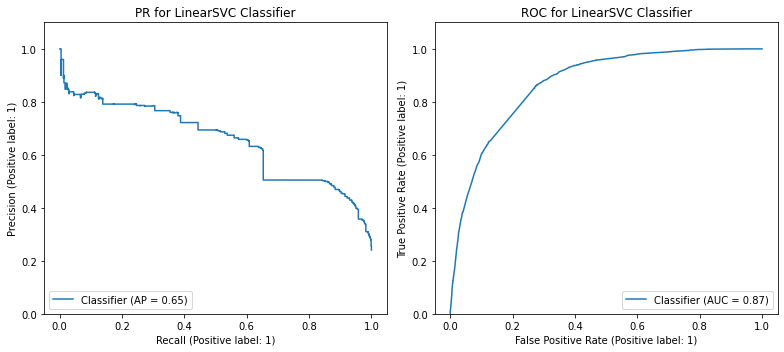

In [424]:
N = 40

weights_wo_scaling = pipeline_wo_scaling[1].coef_[0]
bound = sorted(np.abs(weights_wo_scaling), reverse = True)[N]
idxs = np.where(abs(weights_wo_scaling) >= bound)[0][:N] # вдруг одинаковые веса

print(idxs)

X_train_transformed = onehot_column_transformer_wo_scaling.fit_transform(X_train)
print(X_train_transformed.shape)
X_train_shrinked = X_train_transformed.toarray()[:, idxs]
# X_train_shrinked.shape

logreg_after_shrinkage = LogisticRegression(max_iter = 2 ** 31 - 1)
logreg_after_shrinkage.fit(X_train_shrinked, y_train)

X_test_shrinked = onehot_column_transformer_wo_scaling.transform(X_test).toarray()[:, idxs]

pred = logreg_after_shrinkage.predict_proba(X_test_shrinked)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PR for LinearSVC Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
ax[1].set_title("ROC for LinearSVC Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

AUC-PR получился даже чуть выше, чем когда мы скейлили все признаки, AUC-ROC незначительно упал

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [425]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-23 02:46:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434,15K   447KB/s    in 1,0s    

2022-11-23 02:46:33 (447 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/.

In [426]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [427]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [428]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [432]:
!cat bank-additional/bank-additional-names.txt

In [435]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'day_of_week', 'poutcome',]
numeric_features = list(set(X.columns) - set(categorical_features))
numeric_features

['previous',
 'age',
 'campaign',
 'pdays',
 'euribor3m',
 'emp.var.rate',
 'nr.employed',
 'cons.conf.idx',
 'cons.price.idx']

In [439]:
onehot_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe_and_scaling', onehot_column_transformer),
    ('regression', LogisticRegression(max_iter = 2 ** 31 - 1))
])

iteration = 1
for train_index, test_index in kf.split(X, y):
    X_train, y_train = X.loc[train_index, :], y[train_index]
    X_test, y_test = X.loc[test_index, :], y[test_index]
    
    pipeline.fit(X_train, y_train)
    
    pred = pipeline.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, pred)
    AUC_PR = auc(recall, precision)
    AUC_ROC = roc_auc_score(y_test, pred)
    print(f'for iteration {iteration} AUC-PR is {AUC_PR} and AUC_ROC is {AUC_ROC}')
    iteration += 1

for iteration 1 AUC-PR is 0.4803614700727089 and AUC_ROC is 0.7867103027789494
for iteration 2 AUC-PR is 0.4377834233949101 and AUC_ROC is 0.7907875430074884
for iteration 3 AUC-PR is 0.4500742523628455 and AUC_ROC is 0.7943931599843708
for iteration 4 AUC-PR is 0.4602888724566366 and AUC_ROC is 0.8004228385213138
for iteration 5 AUC-PR is 0.4308771658682701 and AUC_ROC is 0.7840845147879193


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [440]:
total_revenue = 0
call_center_salary = 0

iteration = 1
for train_index, test_index in kf.split(X, y):
    X_train, y_train = X.loc[train_index, :], y[train_index]
    X_test, y_test = X.loc[test_index, :], y[test_index]
    
    pipeline.fit(X_train, y_train)
    
    binary_pred = pipeline.predict(X_test)
    total_revenue += sum(y_test * 10) - sum(binary_pred)
    call_center_salary += sum(binary_pred)

In [441]:
print(f'В среднем будет заработано {total_revenue / 5}, операторам колл-центра придётся отдать в среднем {call_center_salary / 5}')

В среднем будет заработано 8955.6, операторам колл-центра придётся отдать в среднем 324.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [442]:
total_revenue = 0
call_center_salary = 0

iteration = 1
for train_index, test_index in kf.split(X, y):
    X_train, y_train = X.loc[train_index, :], y[train_index]
    X_test, y_test = X.loc[test_index, :], y[test_index]
    
    pipeline.fit(X_train, y_train)
    
    binary_pred = pipeline.predict(X_test)
    total_revenue += sum(y_test * np.random.uniform(0, 20, len(y_test))) - sum(binary_pred)
    call_center_salary += sum(binary_pred)
    
print(f'В среднем будет заработано {total_revenue / 5}, операторам колл-центра придётся отдать в среднем {call_center_salary / 5}')

В среднем будет заработано 8916.251370398235, операторам колл-центра придётся отдать в среднем 324.4


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Если у модели будет высокий precision, услугой воспользуются почти все клиенты, которым мы позвоним; если у модели хороший recall, то в колл-центре позвонят почти всем клиентам, которые готовы воспользоваться услугой. Лучше позвонить нескольким лишним клиентам, чем пропустить клиентов, точно готовых воспользоваться услугой -> для бизнеса важнее хороший precision



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ цезарь-ролл из вкусвилла